Based on a [blog post](https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html)

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import pairwise_distances

import matplotlib.pyplot as plt
%matplotlib inline

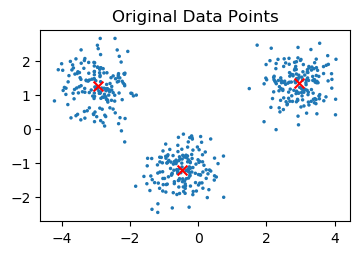

In [2]:
# Run this cell for 3 artificial clusters
N = 500
n_blobs = 3
X, y_true = make_blobs(n_samples=N,
                  n_features=2,
                  centers=n_blobs,
                  cluster_std=0.5, # increase the standard deviation for less well-separated clusters
                  center_box=((-3, -2), (3, 2)),
                  shuffle=True)

# Compute centers
cx = [np.mean(X[y_true==yy,0]) for yy in range(n_blobs)]
cy = [np.mean(X[y_true==yy,1]) for yy in range(n_blobs)]
centers = np.column_stack([cx] + [cy])

# Plot 'em
fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect=1)
ax.scatter(X[:, 0], X[:, 1], marker='.', s=25, edgecolor='')
ax.scatter(centers[:,0], centers[:,1], marker='x', s=50, edgecolor='', c='red', linewidths=0)
ax.set_title('Original Data Points')
plt.show()

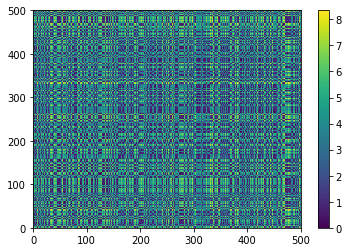

In [3]:
# Display unsorted distance matrix
dist_mat = squareform(pdist(X))
N = len(X)
plt.pcolormesh(dist_mat)
plt.colorbar()
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

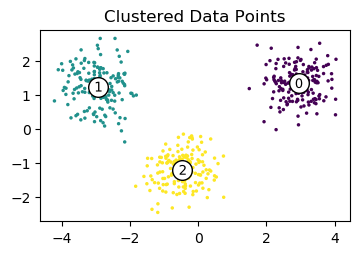

In [4]:
# Find clusters
kmeans = KMeans(n_clusters=n_blobs)
y = kmeans.fit_predict(X)

# Compute centers
cx = [np.mean(X[y==yy,0]) for yy in range(n_blobs)]
cy = [np.mean(X[y==yy,1]) for yy in range(n_blobs)]
centers = np.column_stack([cx] + [cy])

# Plot 'em
fig = plt.figure(figsize=(4, 4), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect=1)
ax.scatter(X[:, 0], X[:, 1], marker='.', s=25, edgecolor='', c=y)
#ax.scatter(cx, cy, marker='x', s=50, edgecolor='', c='red', linewidths=0)
# Label the cluster centers
for i, c in enumerate(centers):
    cl = '${}$'.format(i)
    ax.scatter(c[0], c[1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    ax.scatter(c[0], c[1], marker=cl, alpha=1, s=50, c='k', edgecolor='')

ax.set_title('Clustered Data Points')
plt.show()

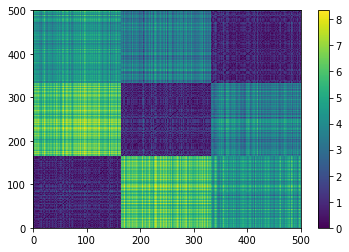

In [14]:
ix = y.argsort()

X_sorted = X[ix]
y_sorted = y[ix]

# Display unsorted distance matrix
dist_mat = squareform(pdist(X_sorted))
N = len(X_sorted)
plt.pcolormesh(dist_mat)
plt.colorbar()
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()

In [6]:
# Compute the pairwise distances among all points
dist_mx = pairwise_distances(X)

In [7]:
# Function to convert distances to similarities in the range 0 to 1
def similarity(x):
    dmin = dist_mx.min()
    dmax = dist_mx.max()
    return(1-((x-dmin)/(dmax-dmin)))

In [8]:
# Compute the pairwise similiarities
sim_mx = similarity(dist_mx)

In [9]:
# Calculate incidence matrix
# 1 if point i and point j are in the same cluster, 0 otherwise
incd_mx = []
for i in y:
    row = []
    for j in y:
        if i == j:
            row.append(1)
        else:
            row.append(0)
    incd_mx.append(row)

incd_mx = np.array(incd_mx)

In [10]:
# Now we can compute the correlation between the incidence matrix
# and the similarity matrix:
corr, pvalue = pearsonr(np.array(sim_mx).reshape(-1,1), np.array(incd_mx).reshape(-1,1))
print(corr)
print(pvalue)

[ 0.85975799]
[ 0.]


Bonus feature: Voronoi diagram of our clustering

In [11]:
# Step size of the mesh.
h = .02

# Define plot boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Define mesh grid that we'll "color in"
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [12]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

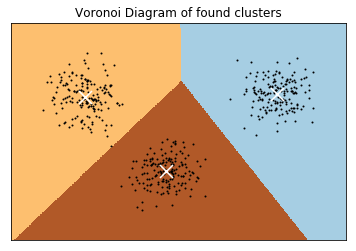

In [13]:
# Plot the mesh grid as an image
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.title('Voronoi Diagram of found clusters')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()